In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns

## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)

In [2]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df    

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_")[0] + "_" + col.split("_")[1] + "_" + col.split("_")[2] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split("source_transcript=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get CHM gene_ids
        df["CHM_gene_id"] = df["other"].str.split("gene_id=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["CHM_transcript_id"] = df["other"].str.split("transcript_id=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get transcript names
        df["transcript_name"] = df["other"].str.split("source_transcript_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get start codon
        df["start_codon"] = df["other"].str.split("adj_start=", expand=True)[1].str.split(";", expand=True)[0]
        
        ## Get stop codon
        df["stop_codon"] = df["other"].str.split("adj_stop=", expand=True)[1].str.split(";", expand=True)[0]        

        ## Only keep relevant
        df = df[["chr", "start", "end", "strand", "type", "gene_id", "transcript_id", "CHM_gene_id",
                 "CHM_transcript_id", "transcript_name", "gene_name", "start_codon", "stop_codon"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        

        ## Get CHM transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Label novel transcripts
        df.loc[df["transcript_id"].str.startswith("tx."), "novel_status"] = "New Transcript Isoform"
        df.loc[~df["transcript_id"].str.startswith("tx."), "novel_status"] = "Annotated"

        ## Label novel genes
        df.loc[df["gene_id"].str.startswith("gene."), "novel_status"] = "New Gene Body"

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
name: make_gene_and_transcript_converter

input: The CHM13 CAT/Liftoff gff annotation version 2.0

output: A dataframe with ["gene_id", "transcript_id", "gene_name", "transcript_name"] formatted in the same way as the 
bambu reference, so that we can properly assign gene and transcript names.

purpose: Creating a list that allows us to assign transcript and gene names to the bambu annotation based on the transcript
id and gene ID
'''


def make_gene_and_transcript_converter(gff):
    
    ## Change name of duplicate Ensembl IDs to CHM IDs
    gff.loc[gff["transcript_id"] == "N/A", "transcript_id"] = gff["CHM_transcript_id"]
    gff_transcripts = gff.loc[gff["type"] == "transcript"].copy()
    gff_transcripts = gff_transcripts[["transcript_id", "CHM_transcript_id"]].drop_duplicates()
    gff_transcripts = gff_transcripts[gff_transcripts['transcript_id'].duplicated() == True]
    dup_trans = gff_transcripts["transcript_id"].dropna().values.tolist()
    gff.loc[gff["transcript_id"].isin(dup_trans), "transcript_id"] = gff["transcript_id"] + "(" + gff["CHM_transcript_id"] + ")"

    ## Change name of duplicate gene ids to CHM ids
    gff.loc[gff["gene_id"] == "None", "gene_id"] = gff["CHM_gene_id"]
    gff_genes = gff.loc[gff["type"] == "transcript"].copy()
    gff_genes = gff_genes[["gene_id", "CHM_gene_id"]].drop_duplicates()
    gff_genes = gff_genes[gff_genes['gene_id'].duplicated() == True]
    dup_genes = gff_genes["gene_id"].dropna().values.tolist()
    gff.loc[gff["gene_id"].isin(dup_genes), "gene_id"] = gff["gene_id"] + "(" + gff["CHM_gene_id"] + ")"

    
    ## Fix gene names for MSTRG Genes
    gff_names = gff.loc[gff["type"] == "transcript"].copy()
    gff_names = gff_names[["gene_id", "gene_name"]].copy()
    gff_names.loc[gff_names["gene_name"].str.contains("MSTRG."), "gene_name"] = np.NaN
    gff_names.dropna(inplace=True)
    gff_names.drop_duplicates(inplace=True, subset=["gene_id"])
    gff.drop(columns="gene_name", inplace=True)
    gff = pd.merge(gff, gff_names, on="gene_id", how="left")
    gff = gff[["gene_id", "transcript_id", "gene_name", "transcript_name",
              "start", "end", "type", "start_codon", "stop_codon", "chr", "strand"]].copy()


    return gff

In [15]:
## Define gene of interest ids

mapt_id = "ENSG00000186868"
app_id = "ENSG00000142192"
snca_id = "ENSG00000145335"
clu_id = "ENSG00000120885"
wnt3_id = "ENSG00000108379"
maob_id = "ENSG00000069535"

new_gene_1 = "gene.93940"
new_gene_2 = "gene.76726"
new_gene_3 = "gene.55973"

genes_names_of_interest = ["MAPT", "APP", "SNCA", "CLU", "WNT3", "MAOB", "new_gene_1", "new_gene_2", "new_gene_3"]

gene_ids_of_interest = [mapt_id, app_id, snca_id, clu_id, wnt3_id, maob_id, new_gene_1, new_gene_2, new_gene_3]

In [11]:
## Fix column names in counts matrix

grch38_counts = pd.read_csv("../../data/raw/merged_uky_cshl_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

grch38_counts = fix_column_names(grch38_counts, is_gene=False)

In [12]:
## Calculate CPM and drop count columns
grch38_counts = calculate_cpm(grch38_counts, is_gene=False)

grch38_counts = grch38_counts[grch38_counts.columns.drop(list(grch38_counts.filter(regex='counts')))]

In [13]:
## Find novel transcripts in both annotations
grch38_counts.loc[grch38_counts["transcript_id"].str.startswith("tx."), "novel_status"] = "New Transcript Isoform"
grch38_counts.loc[~grch38_counts["transcript_id"].str.startswith("tx."), "novel_status"] = "Annotated"

## Find novel genes in both annotations
grch38_counts.loc[grch38_counts["gene_id"].str.startswith("gene."), "novel_status"] = "New Gene Body"

In [14]:
grch38_counts_interest = grch38_counts.loc[grch38_counts["gene_id"].isin(gene_ids_of_interest)].copy()

In [41]:
grch38_counts_interest["CPM_avg"] = ((grch38_counts_interest[['cshl_356_uky_CPM', 'cshl_1271_uky_CPM',
       'cshl_1291_uky_CPM', 'cshl_1304_uky_CPM']].sum(axis=1))/4)

In [42]:
grch38_counts_interest = grch38_counts_interest.loc[grch38_counts_interest["CPM_avg"] > 0.9]

In [43]:
grch38_counts_interest.drop(columns=["CPM_avg"], inplace=True)

In [44]:
cpm_cols = grch38_counts_interest.columns[2:6]

In [45]:
df = pd.melt(grch38_counts_interest, value_vars=cpm_cols, id_vars=['gene_id', "transcript_id", "novel_status"],
             var_name='sample', value_name='CPM')

In [46]:
df.loc[df["sample"] != "cshl_1291_uky_CPM", "disease_status"] = "Control"
df.loc[~(df["sample"] != "cshl_1291_uky_CPM"), "disease_status"] = "AD"

In [47]:
df["sample"] = df["sample"].str.split("_CP", expand=True)[0]

In [58]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 18})
rcParams['axes.linewidth'] = 6

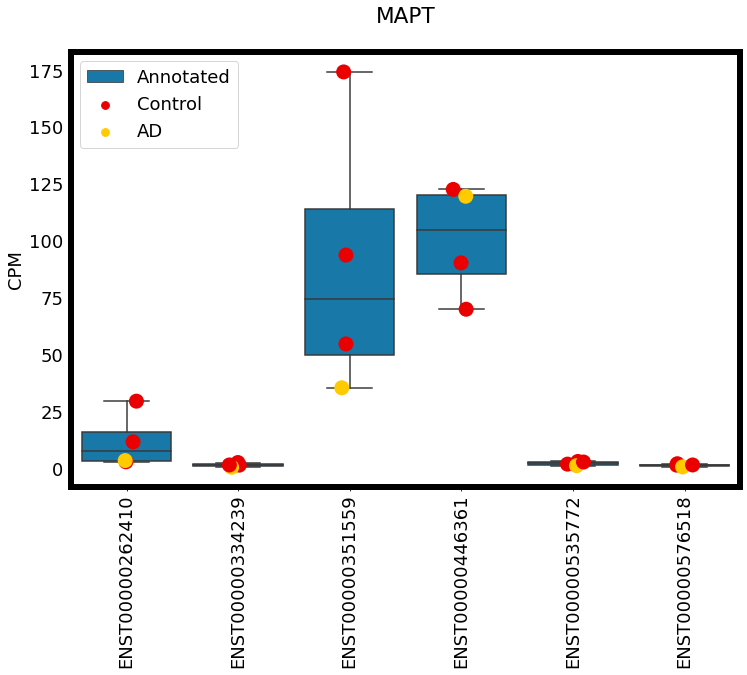

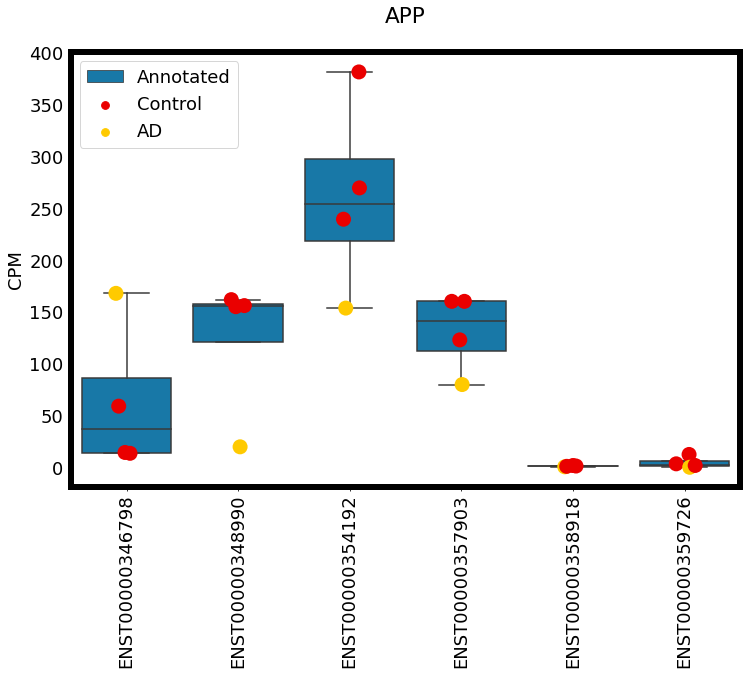

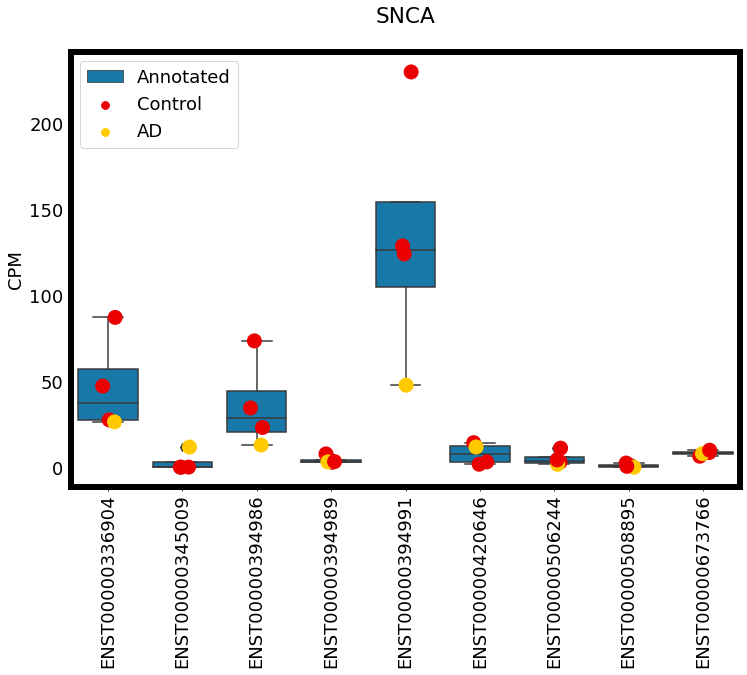

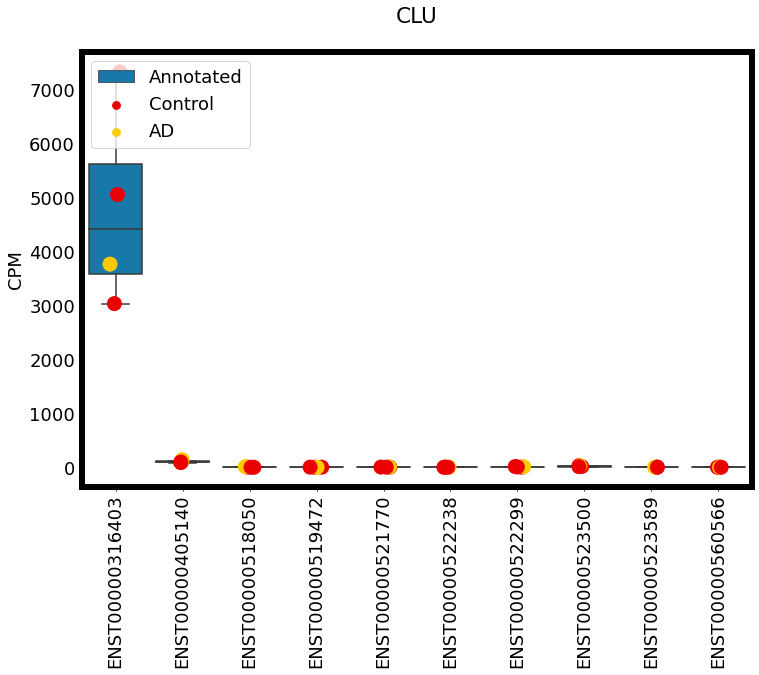

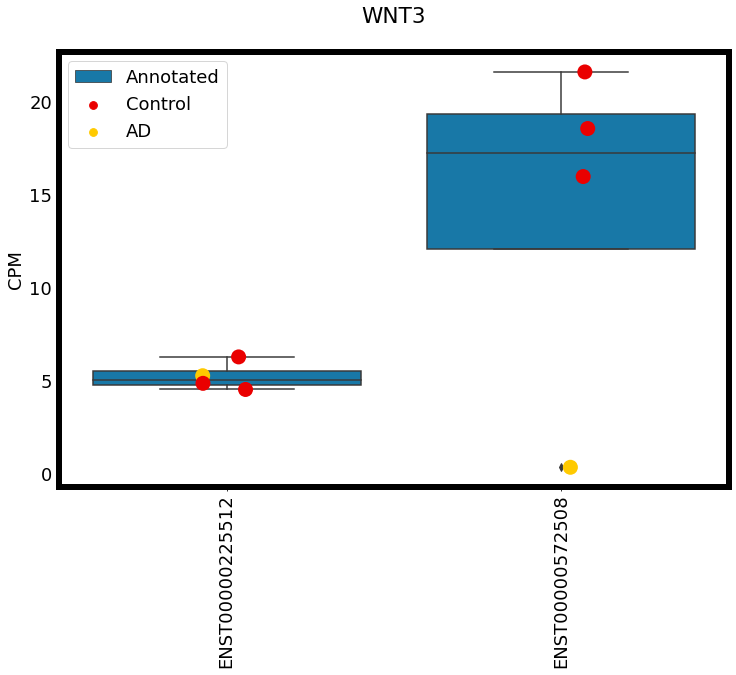

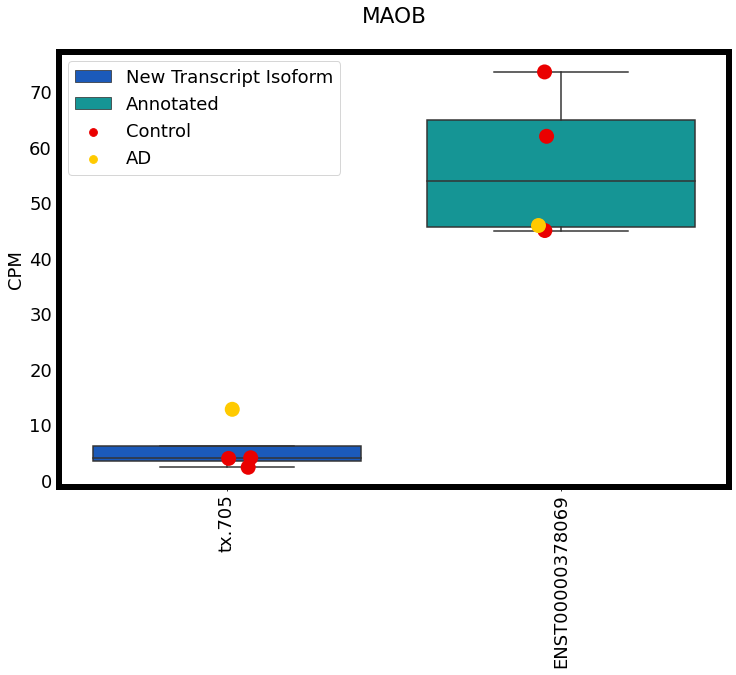

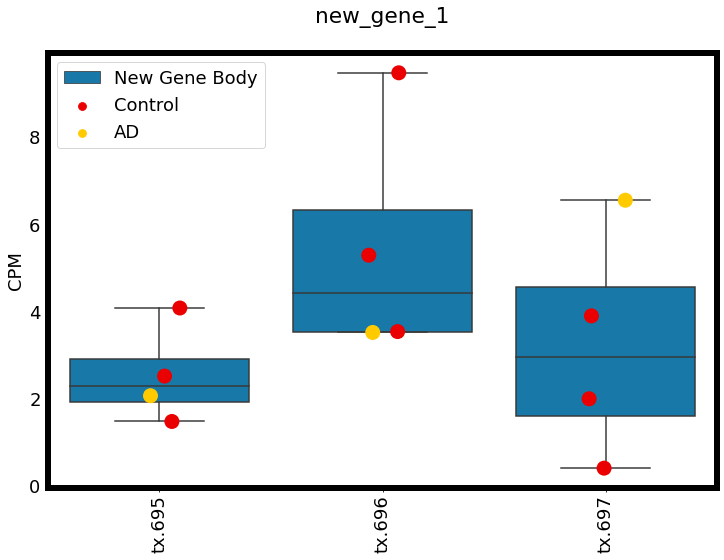

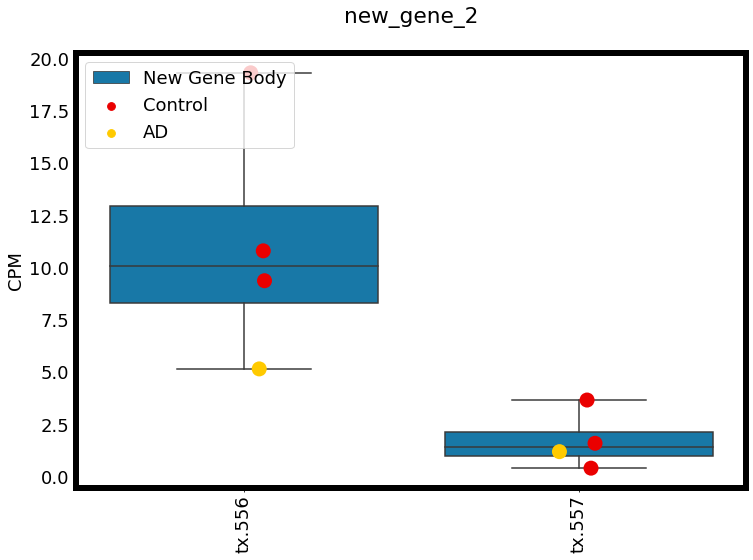

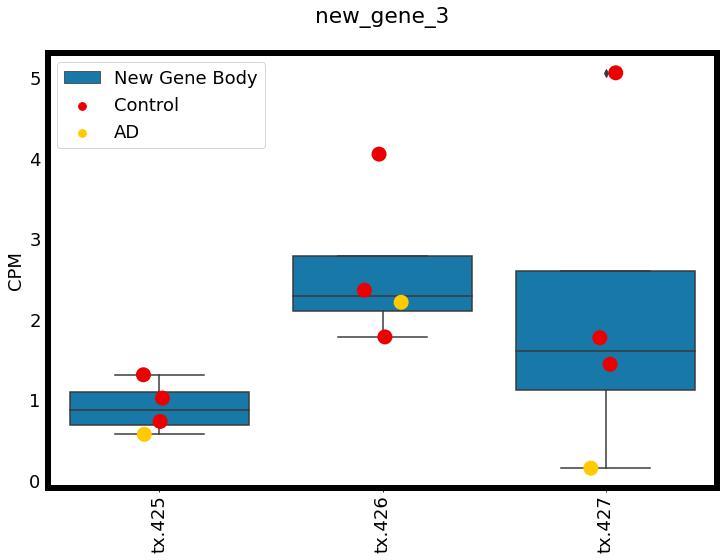

In [64]:
for i in range(len(gene_ids_of_interest)):
    gene_id = gene_ids_of_interest[i]
    gene_name = genes_names_of_interest[i]
    
    df_gene = df.loc[df["gene_id"] == gene_id]
    
    fig, ax = plt.subplots()
    
    sns.boxplot(data=df_gene, x="transcript_id", y="CPM", hue="novel_status", dodge=False, palette="winter",
               ax=ax).set(title=gene_name + "\n")
    
    plt.tick_params(axis='x', labelrotation=90)    
    
    # adding data points
    sns.stripplot(x='transcript_id', y='CPM', hue="disease_status", data=df_gene, palette="hot", size=15, ax=ax)
    plt.legend(loc='upper left')
              
    plt.xlabel("")
    
    output_path = "../../figures/bioinfo_presentation/" + gene_name + "_boxplot.png"
    
    plt.savefig(output_path, dpi=300, transparent=True, bbox_inches="tight")

In [6]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
grch38_ref = pd.read_csv("../../data/processed/annotations_and_quant_for_mark_and_maddie/original_data/extended_annotations.gtf",
                        header=None, delimiter="\t", low_memory=False, 
                        names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


grch38_ref = parse_df_columns(grch38_ref, is_ref=False)

In [7]:
novel_filtered_ref = pd.read_csv("../../data/processed/annotations_and_quant_for_mark_and_maddie/filtered_novel_genes_and_transcripts/new_rna_AVG_cpm_greater_than_one.gtf",
                        header=None, delimiter="\t", low_memory=False, 
                        names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


novel_filtered_ref = parse_df_columns(novel_filtered_ref, is_ref=False)

In [10]:
final_ref = grch38_ref.loc[grch38_ref["novel_status"] == "Annotated"]
final_ref = pd.concat([final_ref, novel_filtered_ref])

In [11]:
## Only keep transcripts
final_ref = final_ref.loc[final_ref["type"].isin(["transcript", "exon"])]

In [13]:
final_ref.tail()

,chr,source,type,start,end,strand,gene_id,transcript_id,exon_number,novel_status
2768,X,Bambu,exon,155299036.0,155299145.0,-,ENSG00000155962,tx.722,2,New Transcript Isoform
2769,X,Bambu,exon,155381874.0,155382030.0,-,ENSG00000155962,tx.722,1,New Transcript Isoform
2770,Y,Bambu,transcript,18932699.0,19077495.0,-,ENSG00000176728,tx.723,NaN,New Transcript Isoform
2771,Y,Bambu,exon,18932699.0,18932841.0,-,ENSG00000176728,tx.723,2,New Transcript Isoform
2772,Y,Bambu,exon,19077268.0,19077495.0,-,ENSG00000176728,tx.723,1,New Transcript Isoform


In [70]:
#grch38_ref = grch38_ref.loc[grch38_ref["transcript_id"].isin(df["transcript_id"])]

In [14]:
final_ref.to_csv("~/novel_annotation_for_cartoons.tsv", index=False, header=False, sep="\t")

##############################################################################################################################
#############################################################################################################################
#############################################################################################################################

In [23]:
## Fix column names in counts matrix

grch38_counts = pd.read_csv("../../data/raw/merged_uky_cshl_GRCh38-107_discovery/bambu_discovery/counts_gene.txt", 
                           delimiter="\t", low_memory=False, header=0)

grch38_counts = fix_column_names(grch38_counts, is_gene=True)

In [24]:
## Calculate CPM and drop count columns
grch38_counts = calculate_cpm(grch38_counts, is_gene=True)

grch38_counts = grch38_counts[grch38_counts.columns.drop(list(grch38_counts.filter(regex='counts')))]

In [25]:
grch38_counts_2 = grch38_counts.loc[grch38_counts["gene_id"].isin(gene_ids_of_interest)].copy()

In [26]:
cpm_cols = grch38_counts_2.columns[1:5]

In [27]:
df = pd.melt(grch38_counts_2, value_vars=cpm_cols, id_vars=['gene_id'],
             var_name='sample', value_name='CPM')

In [29]:
df.loc[df["sample"] != "cshl_1291_uky_CPM", "disease_status"] = "Control"
df.loc[~(df["sample"] != "cshl_1291_uky_CPM"), "disease_status"] = "AD"

In [30]:
df["sample"] = df["sample"].str.split("_CP", expand=True)[0]

In [31]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 18})
rcParams['axes.linewidth'] = 6

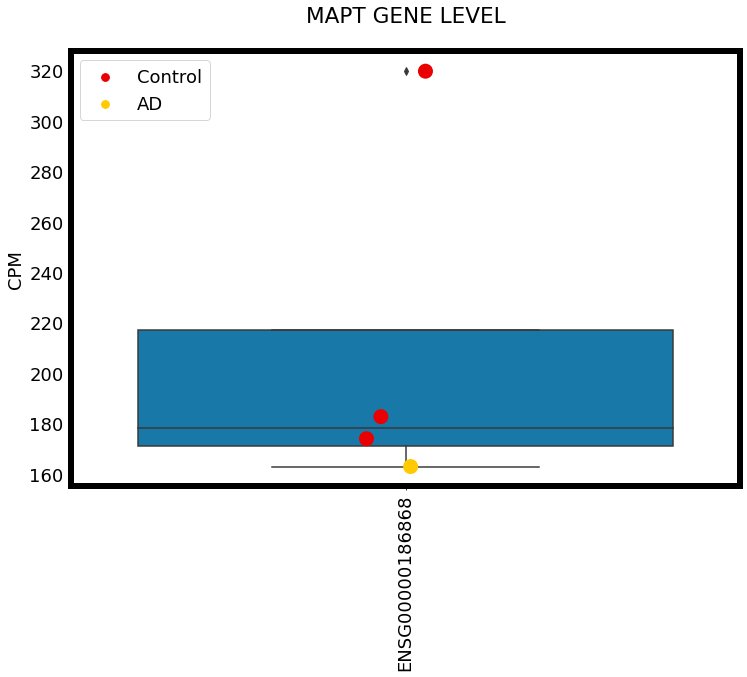

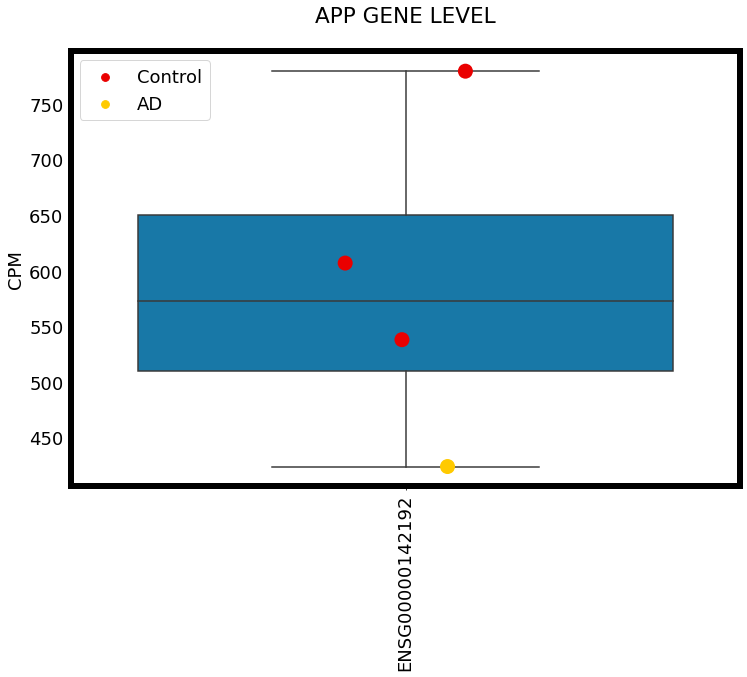

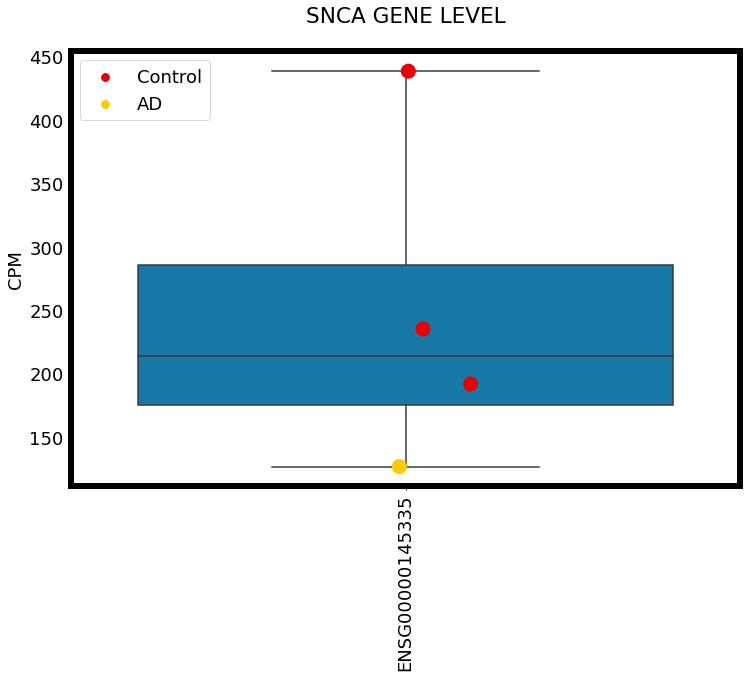

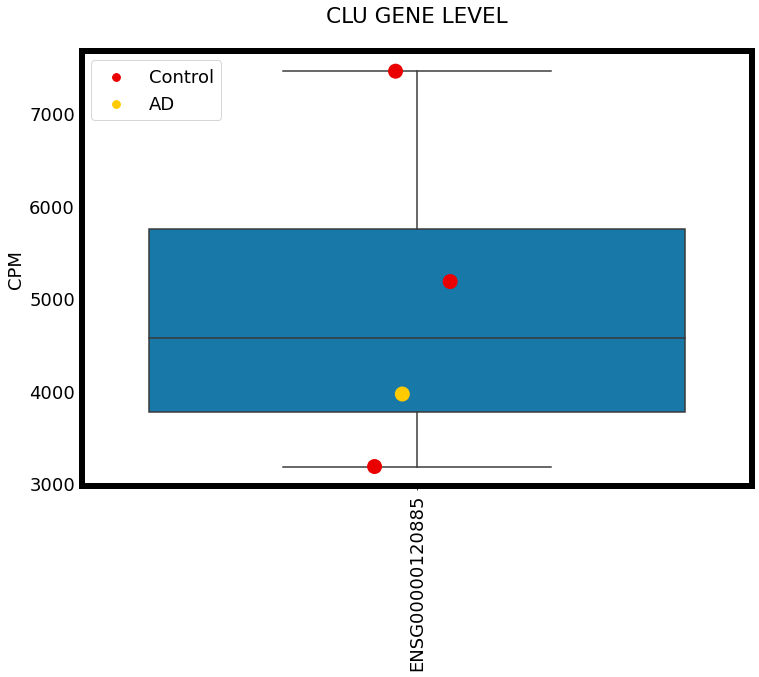

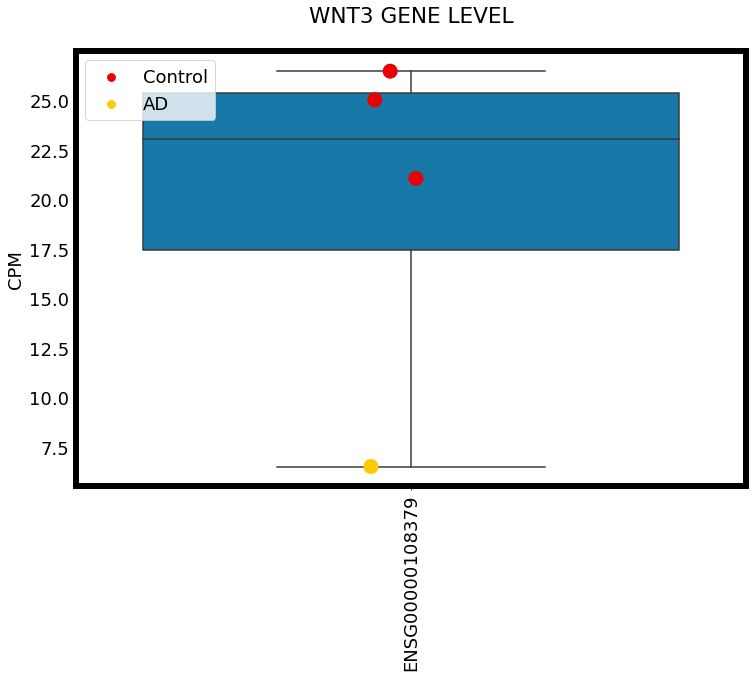

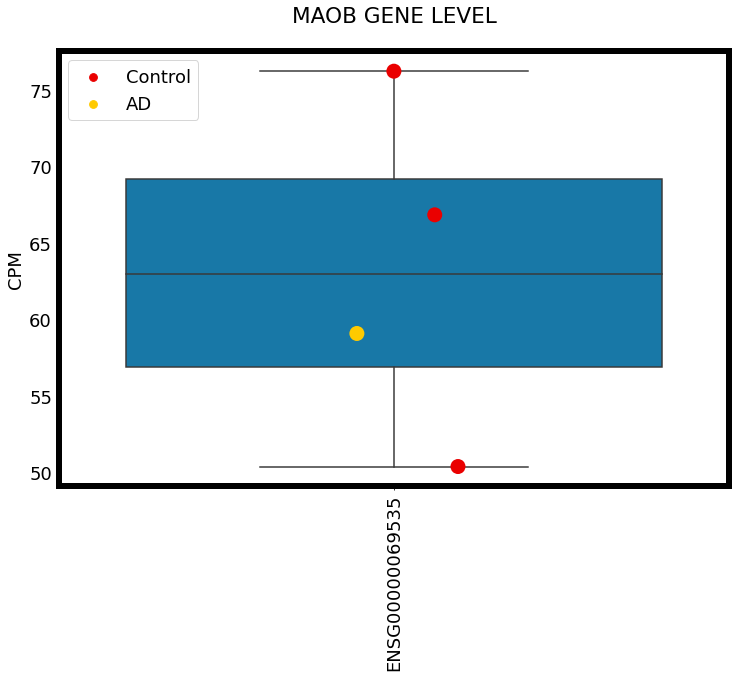

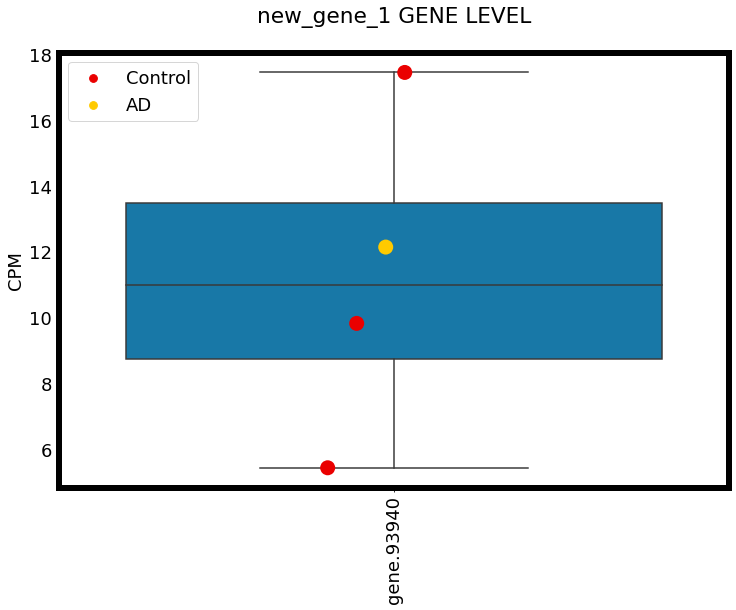

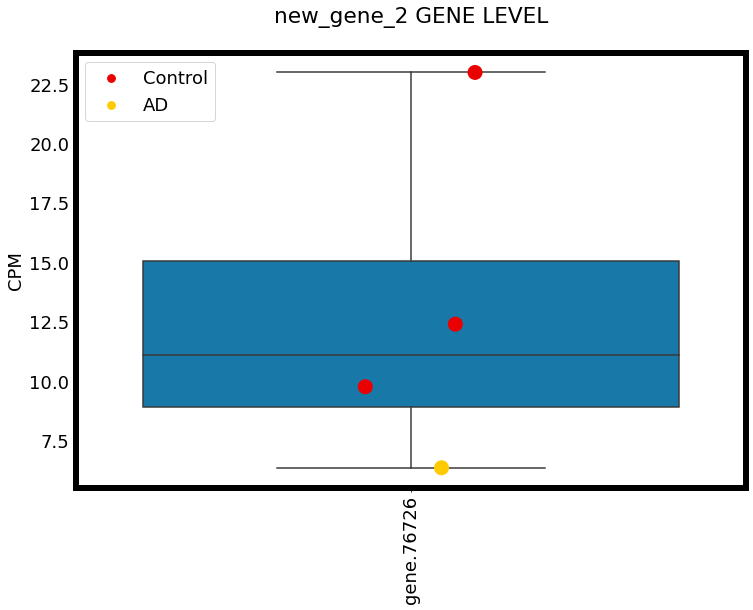

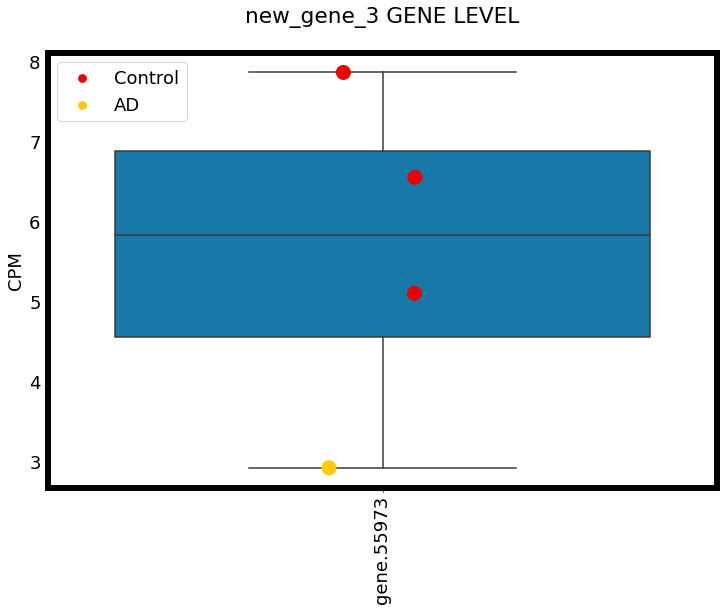

In [32]:
for i in range(len(gene_ids_of_interest)):
    gene_id = gene_ids_of_interest[i]
    gene_name = genes_names_of_interest[i]
    
    df_gene = df.loc[df["gene_id"] == gene_id]
    
    fig, ax = plt.subplots()
    
    sns.boxplot(data=df_gene, x="gene_id", y="CPM", dodge=False, palette="winter",
               ax=ax).set(title=gene_name + " GENE LEVEL\n")
    
    plt.tick_params(axis='x', labelrotation=90)    
    
    # adding data points
    sns.stripplot(x='gene_id', y='CPM', hue="disease_status", data=df_gene, palette="hot", size=15, ax=ax)
    plt.legend(loc='upper left')
              
    plt.xlabel("")
    
    output_path = "../../figures/bioinfo_presentation/" + gene_name + "_boxplot_GENE.png"
    
    plt.savefig(output_path, dpi=300, transparent=True, bbox_inches="tight")